In [40]:
import pickle
from tqdm.auto import tqdm
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss, brier_score_loss, accuracy_score, confusion_matrix

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.optim import Adam

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import INN

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

Using device: cuda


In [3]:
with open('../data/data_train.pt', 'rb') as file:
    X_train, y_train = pickle.load(file)

print(f'{X_train.shape = }')
print(f'{y_train.shape = }')

with open('../data/data_test.pt', 'rb') as file:
    X_test, y_test = pickle.load(file)

print(f'{X_test.shape = }')
print(f'{y_test.shape = }')

sc_X_train = StandardScaler()
X_train_scaled = torch.Tensor(sc_X_train.fit_transform(X_train)).to(device)
X_test_scaled = torch.Tensor(sc_X_train.transform(X_test)).to(device)

y_train = torch.Tensor(y_train).to(device)
# y_test = torch.Tensor(y_test).to(device)

X_train.shape = (2521156, 28)
y_train.shape = (2521156, 2)
X_test.shape = (630290, 28)
y_test.shape = (630290, 2)


In [4]:
loss_weights = {
    'bce_factor': 15,
    'dvg_factor': 1,
    'logdet_factor': .1,
    'rcst_factor': .2
}

In [5]:
batch_size = 1024
n_epochs = 16

In [6]:
inn = INN.INN(X_train.shape[1], y_train.shape[1], n_blocks=5, coupling_network_layers=[128, 128], device=device).to(device)

In [7]:
loss_history = inn.fit(X_train_scaled, y_train, n_epochs=n_epochs, batch_size=batch_size, optimizer=Adam(inn.parameters(), lr=1e-4), loss_weights=loss_weights)

Epoch 15: 100%|██████████| 2462/2462 [00:51<00:00, 47.81it/s, weighted_loss=-1.902, bce=+0.122, dvg=+0.889, rcst=+0.332, logdet=-46.843]


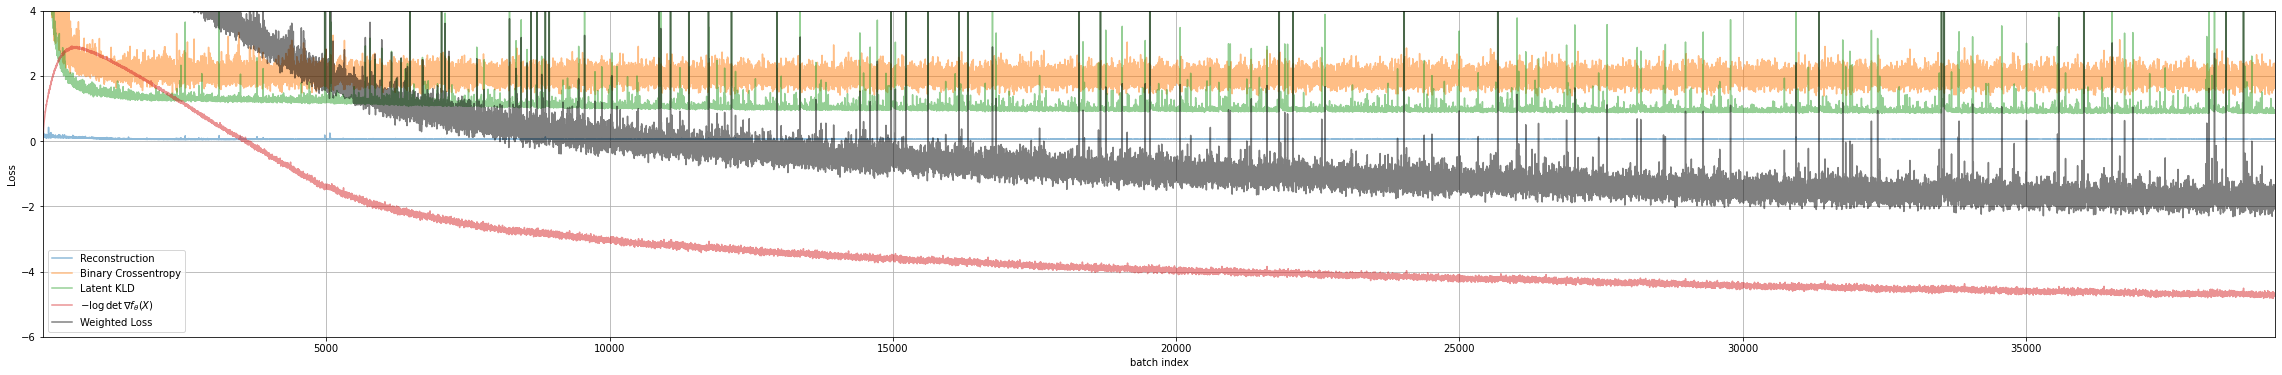

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(40, 6))

ax.plot(loss_history['rcst'], label='Reconstruction', alpha=0.5)
ax.plot(loss_history['bce'], label='Binary Crossentropy', alpha=0.5)
ax.plot(loss_history['dvg'], label='Latent KLD', alpha=0.5)
ax.plot(loss_history['logdet'], label=r'$-\log \det \nabla f_{\theta}(X)$', alpha=0.5)
ax.plot(loss_history['weighted_loss'], label='Weighted Loss', color='black', alpha=0.5)

ax.set_xlim(1, 1+len(loss_history['rcst'])); ax.set_ylim(-6, 4); 
ax.set_xlabel('batch index'); ax.set_ylabel('Loss'); ax.grid()
ax.legend();

In [13]:
inn.eval()

y_pred = np.empty((0, 2))
z_pred = np.empty((0, 26))
for i in tqdm(range(int(np.ceil(len(X_test_scaled) / batch_size)))):
    y_pred_new, z_pred_new = inn.forward(X_test_scaled[i * batch_size: (i+1) * batch_size])
    y_pred = np.concatenate([y_pred, y_pred_new.detach().cpu().numpy()], axis=0)
    z_pred = np.concatenate([z_pred, z_pred_new.detach().cpu().numpy()], axis=0)

100%|██████████| 616/616 [00:09<00:00, 66.83it/s]


In [14]:
for i, y_label in enumerate(['hosp', 'death']):
    print(f'--- {y_label} ---')

    print(f'binary cross-entropy: {np.round(log_loss(y_test[:, i], y_pred[:, i]), 4)}')
    print(f'brier loss: {brier_score_loss(y_test[:, i], y_pred[:, i]).round(4)}')
    print(f'accuracy: {accuracy_score(y_test[:, i], y_pred[:, i] > 0.5).round(4)}')
    print('confusion matrix:')
    print(confusion_matrix(y_test[:, i], y_pred[:, i] > 0.5))
    print()

--- hosp ---
binary cross-entropy: 0.2093
brier loss: 0.0569
accuracy: 0.9314
confusion matrix:
[[585181    441]
 [ 42804   1864]]

--- death ---
binary cross-entropy: 0.0426
brier loss: 0.0109
accuracy: 0.9876
confusion matrix:
[[621458     28]
 [  7782   1022]]



In [17]:
y_sample = torch.Tensor([[0, 1]]*26).to(device)
z_sample = F.one_hot(torch.arange(0, 26)).to(device)

In [20]:
x_sample_pred_scaled = inn.inverse(y_sample, z_sample)

In [23]:
x_sample_pred = sc_X_train.inverse_transform(x_sample_pred_scaled.detach().cpu())

In [59]:
keys = [
    'sex_female',
    'age_0',
    'age_18',
    'age_50',
    'age_65',
    'race_native',
    'race_asian',
    'race_black',
    'race_other',
    'race_native_pacific',
    'race_white',
    'ethnicity_hispanic',
    'case_onset_interval',
    'symptom_status',
    'used_bed_ratio',
    'used_icu_ratio',
    'rural-urban_Continuum Code_2013',
    'urban_influence_code_2013',
    'economic_typology_2015',
    'pop_estimate_2019',
    'less_hs_pct',
    'hs_only_pct',
    'some_college_pct',
    'bachelor_higher_pct',
    'unempl_rate',
    'med_hh_income_19',
    'med_hh_income_pct_state_total_19',
    'poverty_pct_19', 
]

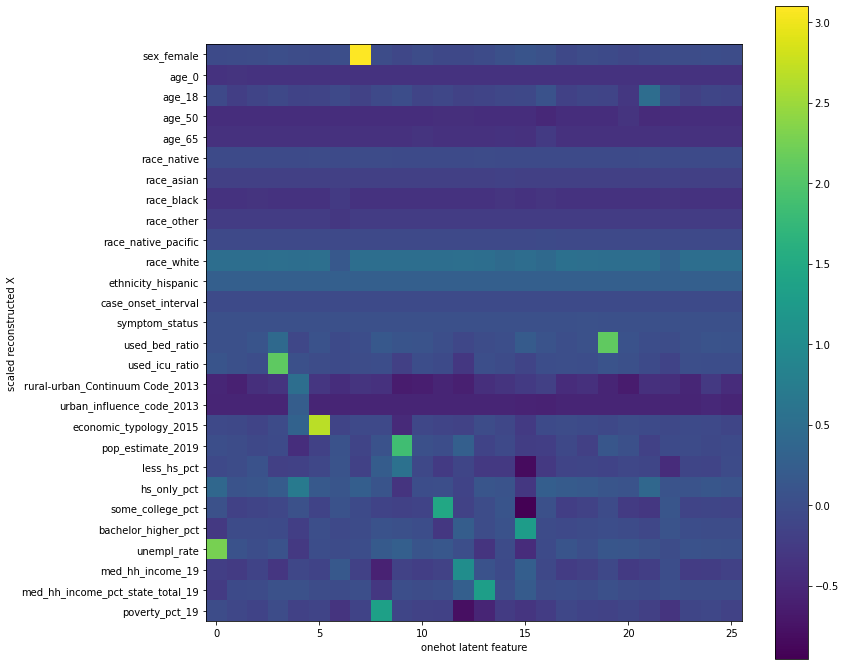

In [67]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
img = ax.imshow(x_sample_pred_scaled.detach().cpu().T);
fig.colorbar(img, ax=ax);
ax.set_xlabel('onehot latent feature'); ax.set_ylabel('scaled reconstructed X');
ax.set_yticks(np.arange(28))
ax.set_yticklabels(keys);